# Linear regression example

Data was taken from: https://www.kaggle.com/mirichoi0218/insurance

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import time

In [2]:
#Get data from csv file
data = pd.read_csv("LinearExample/insurance.csv") 
# Preview the first 5 lines of the loaded data 
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### Check bmi distribution

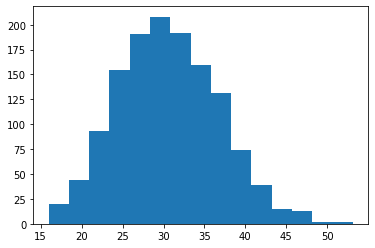

In [3]:
dataNp = data.to_numpy()
bmi = dataNp[:,2]
bmi = bmi.astype('float64')

plt.hist(bmi, bins=15)
plt.show()

### Check charges distribution

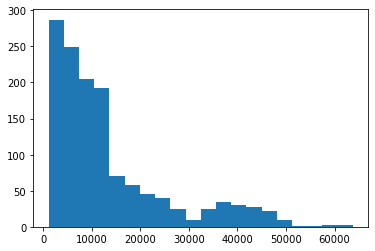

In [4]:
dataNp = data.to_numpy()

age = dataNp[:, 0]
age = age.astype('float64')
sex = dataNp[:, 1]
children = dataNp[:, 3]
charges = dataNp[:, 6]
charges = charges.astype('float64')


plt.hist(charges, bins=20)
plt.show()

### Checking relationship between age and charges

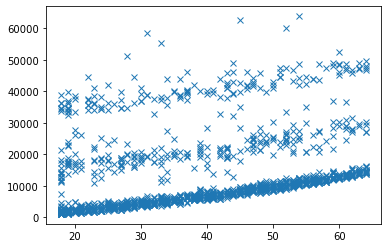

In [5]:
plt.plot(age, charges, 'x');

Checking plot, seems that there is a linear relation between these variables. It's very spreaded though.

Let's try to find a linear equation that fits this data just for fun.

With this visualization, 3 clusters are visible.
How do they relate with other variables?
How can I find the relation between a cluster and another variable(s)?

### Train the model with pytorch

In [6]:
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [7]:
#Get normalize values before spliting sets
ageNorm = np.linalg.norm(age)

#divide train and test dataset
X_train, X_test, y_train, y_test = train_test_split(age, charges, train_size=0.65,test_size=0.35)

#Get data sample sizes
trainDataSize = X_train.size
testDataSize = y_test.size

#normalize data
X_train =  X_train / ageNorm
X_test =  X_test / ageNorm

### Plot after normalization

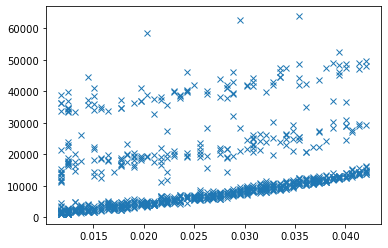

In [8]:
plt.plot(X_train, y_train, 'x');

### Use sklearn to train model and then plot calculated function and train data together

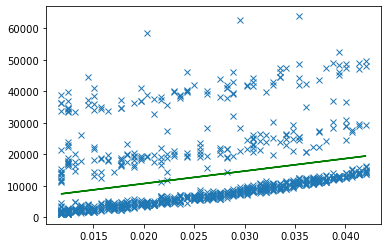

B0: [2809.80924866], B1: [396630.52488458]


In [9]:
from sklearn.linear_model import LinearRegression
linr = LinearRegression()
linr.fit(X_train.reshape(-1,1), y_train.reshape(-1,1))

beta0 = linr.intercept_
beta1 = linr.coef_[0]

yplot = X_train * beta1 + beta0

plt.plot(X_train, y_train, 'x');
plt.plot(X_train, yplot, 'g')
plt.show()

print(f'B0: {beta0}, B1: {beta1}')

### Use pytorch to train model

In [45]:
n_epochs = 1000
batch_size_train = 16
batch_size_test = 20
learning_rate = 0.1
momentum = 0.5
log_interval = 10

# transform to torch tensor
tensor_train_x = torch.Tensor(X_train.reshape(-1, 1))
tensor_train_y = torch.Tensor(y_train.reshape(-1, 1))

# create your datset
train_data = TensorDataset(tensor_train_x, tensor_train_y)

#Create loader using data
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size_train,
    shuffle=True)

# transform to torch tensor
tensor_test_x = torch.Tensor(X_test.reshape(-1, 1))
tensor_test_y = torch.Tensor(y_test.reshape(-1, 1))

# create your datset
test_data = TensorDataset(tensor_test_x, tensor_test_y)

#Create loader using data
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size_test,
    shuffle=True)

In [46]:
class LayerLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # Instead of our custom parameters, we use a Linear layer with single input and single output
        self.linear = nn.Linear(1, 1)
                
    def forward(self, x):
        # Now it only takes a call to the layer to make predictions
        return self.linear(x)
    
#Network model
network = LayerLinearRegression()

#Configure loss function
LossFunction = nn.MSELoss(reduction='mean')

#Stochastic gradient decent
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [47]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [48]:
def train(epoch):
  #Configure network for training
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    
    #set parameters gradients to 0
    optimizer.zero_grad()
    
    #runs model with data and returns result in output
    #here data contains a 64 * 1 * 28 * 28 tensor, 64 is batch size
    output = network(data)
    
    #Use negative log likelihood loss.
    loss = LossFunction(output, target)
    
    #with this gradients are calculated
    loss.backward()
    
    #update gradients
    optimizer.step()
    
    #Display iteration statistics
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'results/model.pth')
      torch.save(optimizer.state_dict(), 'results/optimizer.pth')

In [49]:
def test():
  #Sets the module in evaluation mode
  network.eval()
  test_loss = 0
  correct = 0
    
  #dont update dynamic computation graph
  with torch.no_grad():
    #for every example in test
    for data, target in test_loader:
      #evaluate the model
      output = network(data)
        
      #acumulate the loss
      test_loss += LossFunction(output, target).item()
      
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [54]:
#Check accuaracy before training
test()
tic = time.perf_counter()

for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()
    
toc = time.perf_counter()

print(f"Time elapsed: {toc - tic:0.4f} seconds")


Test set: Avg. loss: 7512699.0320, Accuracy: 0/469 (0%)

Train Epoch: 1 [0/869 (0%)]	Loss: 132995928.000000
Train Epoch: 1 [160/869 (18%)]	Loss: 94727888.000000
Train Epoch: 1 [320/869 (36%)]	Loss: 39330016.000000
Train Epoch: 1 [480/869 (55%)]	Loss: 119759960.000000
Train Epoch: 1 [640/869 (73%)]	Loss: 72515528.000000
Train Epoch: 1 [800/869 (91%)]	Loss: 159702864.000000

Test set: Avg. loss: 7699766.4051, Accuracy: 0/469 (0%)

Train Epoch: 2 [0/869 (0%)]	Loss: 120988152.000000
Train Epoch: 2 [160/869 (18%)]	Loss: 95570704.000000
Train Epoch: 2 [320/869 (36%)]	Loss: 43704900.000000
Train Epoch: 2 [480/869 (55%)]	Loss: 232338512.000000
Train Epoch: 2 [640/869 (73%)]	Loss: 77343488.000000
Train Epoch: 2 [800/869 (91%)]	Loss: 85070336.000000

Test set: Avg. loss: 7404207.4115, Accuracy: 0/469 (0%)

Train Epoch: 3 [0/869 (0%)]	Loss: 66822616.000000
Train Epoch: 3 [160/869 (18%)]	Loss: 81168176.000000
Train Epoch: 3 [320/869 (36%)]	Loss: 143722128.000000
Train Epoch: 3 [480/869 (55%)]	Los


Test set: Avg. loss: 7353764.6055, Accuracy: 0/469 (0%)

Train Epoch: 23 [0/869 (0%)]	Loss: 133764528.000000
Train Epoch: 23 [160/869 (18%)]	Loss: 105787104.000000
Train Epoch: 23 [320/869 (36%)]	Loss: 40288176.000000
Train Epoch: 23 [480/869 (55%)]	Loss: 27395266.000000
Train Epoch: 23 [640/869 (73%)]	Loss: 137696784.000000
Train Epoch: 23 [800/869 (91%)]	Loss: 131029864.000000

Test set: Avg. loss: 8231261.0235, Accuracy: 0/469 (0%)

Train Epoch: 24 [0/869 (0%)]	Loss: 74248768.000000
Train Epoch: 24 [160/869 (18%)]	Loss: 87740032.000000
Train Epoch: 24 [320/869 (36%)]	Loss: 137454352.000000
Train Epoch: 24 [480/869 (55%)]	Loss: 183529280.000000
Train Epoch: 24 [640/869 (73%)]	Loss: 99240088.000000
Train Epoch: 24 [800/869 (91%)]	Loss: 71938592.000000

Test set: Avg. loss: 7501279.7271, Accuracy: 0/469 (0%)

Train Epoch: 25 [0/869 (0%)]	Loss: 177684896.000000
Train Epoch: 25 [160/869 (18%)]	Loss: 96611792.000000
Train Epoch: 25 [320/869 (36%)]	Loss: 101739864.000000
Train Epoch: 25 [

Train Epoch: 46 [0/869 (0%)]	Loss: 115731488.000000
Train Epoch: 46 [160/869 (18%)]	Loss: 360151776.000000
Train Epoch: 46 [320/869 (36%)]	Loss: 215490544.000000
Train Epoch: 46 [480/869 (55%)]	Loss: 99279328.000000
Train Epoch: 46 [640/869 (73%)]	Loss: 70950632.000000
Train Epoch: 46 [800/869 (91%)]	Loss: 46722840.000000

Test set: Avg. loss: 7668666.0981, Accuracy: 0/469 (0%)

Train Epoch: 47 [0/869 (0%)]	Loss: 49547788.000000
Train Epoch: 47 [160/869 (18%)]	Loss: 153443840.000000
Train Epoch: 47 [320/869 (36%)]	Loss: 233633856.000000
Train Epoch: 47 [480/869 (55%)]	Loss: 38500816.000000
Train Epoch: 47 [640/869 (73%)]	Loss: 50640072.000000
Train Epoch: 47 [800/869 (91%)]	Loss: 167625664.000000

Test set: Avg. loss: 7478169.0576, Accuracy: 0/469 (0%)

Train Epoch: 48 [0/869 (0%)]	Loss: 51912148.000000
Train Epoch: 48 [160/869 (18%)]	Loss: 113363208.000000
Train Epoch: 48 [320/869 (36%)]	Loss: 37553788.000000
Train Epoch: 48 [480/869 (55%)]	Loss: 159226288.000000
Train Epoch: 48 [640/

Train Epoch: 68 [640/869 (73%)]	Loss: 226593840.000000
Train Epoch: 68 [800/869 (91%)]	Loss: 69731184.000000

Test set: Avg. loss: 7554536.1876, Accuracy: 0/469 (0%)

Train Epoch: 69 [0/869 (0%)]	Loss: 143708544.000000
Train Epoch: 69 [160/869 (18%)]	Loss: 43147168.000000
Train Epoch: 69 [320/869 (36%)]	Loss: 148884464.000000
Train Epoch: 69 [480/869 (55%)]	Loss: 169197216.000000
Train Epoch: 69 [640/869 (73%)]	Loss: 130784944.000000
Train Epoch: 69 [800/869 (91%)]	Loss: 56086864.000000

Test set: Avg. loss: 7567506.8145, Accuracy: 0/469 (0%)

Train Epoch: 70 [0/869 (0%)]	Loss: 84430136.000000
Train Epoch: 70 [160/869 (18%)]	Loss: 109279280.000000
Train Epoch: 70 [320/869 (36%)]	Loss: 223898640.000000
Train Epoch: 70 [480/869 (55%)]	Loss: 121744744.000000
Train Epoch: 70 [640/869 (73%)]	Loss: 124746872.000000
Train Epoch: 70 [800/869 (91%)]	Loss: 104206928.000000

Test set: Avg. loss: 7493825.9104, Accuracy: 0/469 (0%)

Train Epoch: 71 [0/869 (0%)]	Loss: 47084904.000000
Train Epoch: 71

Train Epoch: 91 [0/869 (0%)]	Loss: 139935616.000000
Train Epoch: 91 [160/869 (18%)]	Loss: 134927216.000000
Train Epoch: 91 [320/869 (36%)]	Loss: 325516800.000000
Train Epoch: 91 [480/869 (55%)]	Loss: 170768016.000000
Train Epoch: 91 [640/869 (73%)]	Loss: 107069472.000000
Train Epoch: 91 [800/869 (91%)]	Loss: 232838416.000000

Test set: Avg. loss: 7565353.6290, Accuracy: 0/469 (0%)

Train Epoch: 92 [0/869 (0%)]	Loss: 42278880.000000
Train Epoch: 92 [160/869 (18%)]	Loss: 60152616.000000
Train Epoch: 92 [320/869 (36%)]	Loss: 112364416.000000
Train Epoch: 92 [480/869 (55%)]	Loss: 229886336.000000
Train Epoch: 92 [640/869 (73%)]	Loss: 215975360.000000
Train Epoch: 92 [800/869 (91%)]	Loss: 90044936.000000

Test set: Avg. loss: 7757263.0704, Accuracy: 0/469 (0%)

Train Epoch: 93 [0/869 (0%)]	Loss: 139184320.000000
Train Epoch: 93 [160/869 (18%)]	Loss: 136136544.000000
Train Epoch: 93 [320/869 (36%)]	Loss: 131669304.000000
Train Epoch: 93 [480/869 (55%)]	Loss: 144973328.000000
Train Epoch: 93 

Train Epoch: 113 [800/869 (91%)]	Loss: 126248680.000000

Test set: Avg. loss: 7808854.0640, Accuracy: 0/469 (0%)

Train Epoch: 114 [0/869 (0%)]	Loss: 113518848.000000
Train Epoch: 114 [160/869 (18%)]	Loss: 112345888.000000
Train Epoch: 114 [320/869 (36%)]	Loss: 232955712.000000
Train Epoch: 114 [480/869 (55%)]	Loss: 137493920.000000
Train Epoch: 114 [640/869 (73%)]	Loss: 128246472.000000
Train Epoch: 114 [800/869 (91%)]	Loss: 127112128.000000

Test set: Avg. loss: 7439599.4200, Accuracy: 0/469 (0%)

Train Epoch: 115 [0/869 (0%)]	Loss: 92455440.000000
Train Epoch: 115 [160/869 (18%)]	Loss: 201746704.000000
Train Epoch: 115 [320/869 (36%)]	Loss: 214156624.000000
Train Epoch: 115 [480/869 (55%)]	Loss: 247071104.000000
Train Epoch: 115 [640/869 (73%)]	Loss: 119008664.000000
Train Epoch: 115 [800/869 (91%)]	Loss: 97504432.000000

Test set: Avg. loss: 7533057.2281, Accuracy: 0/469 (0%)

Train Epoch: 116 [0/869 (0%)]	Loss: 94564256.000000
Train Epoch: 116 [160/869 (18%)]	Loss: 137660976.00000

Train Epoch: 136 [320/869 (36%)]	Loss: 38674044.000000
Train Epoch: 136 [480/869 (55%)]	Loss: 248674208.000000
Train Epoch: 136 [640/869 (73%)]	Loss: 118646888.000000
Train Epoch: 136 [800/869 (91%)]	Loss: 90763288.000000

Test set: Avg. loss: 7406328.4691, Accuracy: 0/469 (0%)

Train Epoch: 137 [0/869 (0%)]	Loss: 129529840.000000
Train Epoch: 137 [160/869 (18%)]	Loss: 87880024.000000
Train Epoch: 137 [320/869 (36%)]	Loss: 103623864.000000
Train Epoch: 137 [480/869 (55%)]	Loss: 110280480.000000
Train Epoch: 137 [640/869 (73%)]	Loss: 113349392.000000
Train Epoch: 137 [800/869 (91%)]	Loss: 47791156.000000

Test set: Avg. loss: 7392792.6482, Accuracy: 0/469 (0%)

Train Epoch: 138 [0/869 (0%)]	Loss: 88217432.000000
Train Epoch: 138 [160/869 (18%)]	Loss: 139421504.000000
Train Epoch: 138 [320/869 (36%)]	Loss: 99692960.000000
Train Epoch: 138 [480/869 (55%)]	Loss: 273547520.000000
Train Epoch: 138 [640/869 (73%)]	Loss: 153123744.000000
Train Epoch: 138 [800/869 (91%)]	Loss: 136966800.000000


Train Epoch: 158 [480/869 (55%)]	Loss: 216008816.000000
Train Epoch: 158 [640/869 (73%)]	Loss: 73718264.000000
Train Epoch: 158 [800/869 (91%)]	Loss: 179426208.000000

Test set: Avg. loss: 7364247.7612, Accuracy: 0/469 (0%)

Train Epoch: 159 [0/869 (0%)]	Loss: 85359976.000000
Train Epoch: 159 [160/869 (18%)]	Loss: 282299232.000000
Train Epoch: 159 [320/869 (36%)]	Loss: 144834656.000000
Train Epoch: 159 [480/869 (55%)]	Loss: 192207216.000000
Train Epoch: 159 [640/869 (73%)]	Loss: 132938664.000000
Train Epoch: 159 [800/869 (91%)]	Loss: 175066080.000000

Test set: Avg. loss: 7718851.3945, Accuracy: 0/469 (0%)

Train Epoch: 160 [0/869 (0%)]	Loss: 148392064.000000
Train Epoch: 160 [160/869 (18%)]	Loss: 93007792.000000
Train Epoch: 160 [320/869 (36%)]	Loss: 27979628.000000
Train Epoch: 160 [480/869 (55%)]	Loss: 160349376.000000
Train Epoch: 160 [640/869 (73%)]	Loss: 106220520.000000
Train Epoch: 160 [800/869 (91%)]	Loss: 83123496.000000

Test set: Avg. loss: 8163219.3774, Accuracy: 0/469 (0%

Train Epoch: 181 [480/869 (55%)]	Loss: 193031520.000000
Train Epoch: 181 [640/869 (73%)]	Loss: 122818912.000000
Train Epoch: 181 [800/869 (91%)]	Loss: 81206304.000000

Test set: Avg. loss: 7554250.1493, Accuracy: 0/469 (0%)

Train Epoch: 182 [0/869 (0%)]	Loss: 130328040.000000
Train Epoch: 182 [160/869 (18%)]	Loss: 186697872.000000
Train Epoch: 182 [320/869 (36%)]	Loss: 302335296.000000
Train Epoch: 182 [480/869 (55%)]	Loss: 162629600.000000
Train Epoch: 182 [640/869 (73%)]	Loss: 43228148.000000
Train Epoch: 182 [800/869 (91%)]	Loss: 129462016.000000

Test set: Avg. loss: 7420928.2388, Accuracy: 0/469 (0%)

Train Epoch: 183 [0/869 (0%)]	Loss: 142397472.000000
Train Epoch: 183 [160/869 (18%)]	Loss: 87084696.000000
Train Epoch: 183 [320/869 (36%)]	Loss: 188404112.000000
Train Epoch: 183 [480/869 (55%)]	Loss: 62715560.000000
Train Epoch: 183 [640/869 (73%)]	Loss: 140763392.000000
Train Epoch: 183 [800/869 (91%)]	Loss: 166532160.000000

Test set: Avg. loss: 7394941.1045, Accuracy: 0/469 (0

Train Epoch: 203 [800/869 (91%)]	Loss: 132068288.000000

Test set: Avg. loss: 7757511.4200, Accuracy: 0/469 (0%)

Train Epoch: 204 [0/869 (0%)]	Loss: 79325608.000000
Train Epoch: 204 [160/869 (18%)]	Loss: 240594112.000000
Train Epoch: 204 [320/869 (36%)]	Loss: 138743504.000000
Train Epoch: 204 [480/869 (55%)]	Loss: 184948480.000000
Train Epoch: 204 [640/869 (73%)]	Loss: 77541536.000000
Train Epoch: 204 [800/869 (91%)]	Loss: 209264720.000000

Test set: Avg. loss: 7464103.6588, Accuracy: 0/469 (0%)

Train Epoch: 205 [0/869 (0%)]	Loss: 87898024.000000
Train Epoch: 205 [160/869 (18%)]	Loss: 156791312.000000
Train Epoch: 205 [320/869 (36%)]	Loss: 147826528.000000
Train Epoch: 205 [480/869 (55%)]	Loss: 79453080.000000
Train Epoch: 205 [640/869 (73%)]	Loss: 36913440.000000
Train Epoch: 205 [800/869 (91%)]	Loss: 78910464.000000

Test set: Avg. loss: 7544514.2004, Accuracy: 0/469 (0%)

Train Epoch: 206 [0/869 (0%)]	Loss: 128538304.000000
Train Epoch: 206 [160/869 (18%)]	Loss: 105701432.000000
T

Train Epoch: 226 [800/869 (91%)]	Loss: 144123680.000000

Test set: Avg. loss: 7594508.7761, Accuracy: 0/469 (0%)

Train Epoch: 227 [0/869 (0%)]	Loss: 132850960.000000
Train Epoch: 227 [160/869 (18%)]	Loss: 154958656.000000
Train Epoch: 227 [320/869 (36%)]	Loss: 432075424.000000
Train Epoch: 227 [480/869 (55%)]	Loss: 96728704.000000
Train Epoch: 227 [640/869 (73%)]	Loss: 190057888.000000
Train Epoch: 227 [800/869 (91%)]	Loss: 90204928.000000

Test set: Avg. loss: 7470473.2537, Accuracy: 0/469 (0%)

Train Epoch: 228 [0/869 (0%)]	Loss: 239231584.000000
Train Epoch: 228 [160/869 (18%)]	Loss: 59058800.000000
Train Epoch: 228 [320/869 (36%)]	Loss: 162017664.000000
Train Epoch: 228 [480/869 (55%)]	Loss: 143897264.000000
Train Epoch: 228 [640/869 (73%)]	Loss: 75112784.000000
Train Epoch: 228 [800/869 (91%)]	Loss: 90822032.000000

Test set: Avg. loss: 7487556.0256, Accuracy: 0/469 (0%)

Train Epoch: 229 [0/869 (0%)]	Loss: 126724392.000000
Train Epoch: 229 [160/869 (18%)]	Loss: 209861952.000000


Train Epoch: 249 [800/869 (91%)]	Loss: 103208136.000000

Test set: Avg. loss: 7526853.9360, Accuracy: 0/469 (0%)

Train Epoch: 250 [0/869 (0%)]	Loss: 125405576.000000
Train Epoch: 250 [160/869 (18%)]	Loss: 183503568.000000
Train Epoch: 250 [320/869 (36%)]	Loss: 273324704.000000
Train Epoch: 250 [480/869 (55%)]	Loss: 166774016.000000
Train Epoch: 250 [640/869 (73%)]	Loss: 73973096.000000
Train Epoch: 250 [800/869 (91%)]	Loss: 42843172.000000

Test set: Avg. loss: 7612630.0725, Accuracy: 0/469 (0%)

Train Epoch: 251 [0/869 (0%)]	Loss: 82725328.000000
Train Epoch: 251 [160/869 (18%)]	Loss: 94735160.000000
Train Epoch: 251 [320/869 (36%)]	Loss: 182143904.000000
Train Epoch: 251 [480/869 (55%)]	Loss: 76729584.000000
Train Epoch: 251 [640/869 (73%)]	Loss: 144067248.000000
Train Epoch: 251 [800/869 (91%)]	Loss: 152269072.000000

Test set: Avg. loss: 7552162.9680, Accuracy: 0/469 (0%)

Train Epoch: 252 [0/869 (0%)]	Loss: 34928332.000000
Train Epoch: 252 [160/869 (18%)]	Loss: 216255792.000000
T

Train Epoch: 272 [640/869 (73%)]	Loss: 34281064.000000
Train Epoch: 272 [800/869 (91%)]	Loss: 150022736.000000

Test set: Avg. loss: 8209266.5075, Accuracy: 0/469 (0%)

Train Epoch: 273 [0/869 (0%)]	Loss: 157374624.000000
Train Epoch: 273 [160/869 (18%)]	Loss: 96789288.000000
Train Epoch: 273 [320/869 (36%)]	Loss: 54893108.000000
Train Epoch: 273 [480/869 (55%)]	Loss: 195952848.000000
Train Epoch: 273 [640/869 (73%)]	Loss: 95225272.000000
Train Epoch: 273 [800/869 (91%)]	Loss: 196282096.000000

Test set: Avg. loss: 7604159.3348, Accuracy: 0/469 (0%)

Train Epoch: 274 [0/869 (0%)]	Loss: 70473768.000000
Train Epoch: 274 [160/869 (18%)]	Loss: 99285352.000000
Train Epoch: 274 [320/869 (36%)]	Loss: 78039552.000000
Train Epoch: 274 [480/869 (55%)]	Loss: 89112688.000000
Train Epoch: 274 [640/869 (73%)]	Loss: 218615024.000000
Train Epoch: 274 [800/869 (91%)]	Loss: 143498880.000000

Test set: Avg. loss: 7347288.2814, Accuracy: 0/469 (0%)

Train Epoch: 275 [0/869 (0%)]	Loss: 44574752.000000
Trai

Train Epoch: 295 [320/869 (36%)]	Loss: 173565472.000000
Train Epoch: 295 [480/869 (55%)]	Loss: 145798368.000000
Train Epoch: 295 [640/869 (73%)]	Loss: 113141952.000000
Train Epoch: 295 [800/869 (91%)]	Loss: 166588816.000000

Test set: Avg. loss: 7598671.6077, Accuracy: 0/469 (0%)

Train Epoch: 296 [0/869 (0%)]	Loss: 190111120.000000
Train Epoch: 296 [160/869 (18%)]	Loss: 115534024.000000
Train Epoch: 296 [320/869 (36%)]	Loss: 141288416.000000
Train Epoch: 296 [480/869 (55%)]	Loss: 127819440.000000
Train Epoch: 296 [640/869 (73%)]	Loss: 169215936.000000
Train Epoch: 296 [800/869 (91%)]	Loss: 84319632.000000

Test set: Avg. loss: 7354852.7164, Accuracy: 0/469 (0%)

Train Epoch: 297 [0/869 (0%)]	Loss: 148080688.000000
Train Epoch: 297 [160/869 (18%)]	Loss: 173486304.000000
Train Epoch: 297 [320/869 (36%)]	Loss: 257174464.000000
Train Epoch: 297 [480/869 (55%)]	Loss: 67712400.000000
Train Epoch: 297 [640/869 (73%)]	Loss: 76588744.000000
Train Epoch: 297 [800/869 (91%)]	Loss: 121906912.0000

Train Epoch: 318 [640/869 (73%)]	Loss: 141352832.000000
Train Epoch: 318 [800/869 (91%)]	Loss: 312740320.000000

Test set: Avg. loss: 7399130.7548, Accuracy: 0/469 (0%)

Train Epoch: 319 [0/869 (0%)]	Loss: 89305448.000000
Train Epoch: 319 [160/869 (18%)]	Loss: 175907728.000000
Train Epoch: 319 [320/869 (36%)]	Loss: 253694464.000000
Train Epoch: 319 [480/869 (55%)]	Loss: 126685648.000000
Train Epoch: 319 [640/869 (73%)]	Loss: 196436160.000000
Train Epoch: 319 [800/869 (91%)]	Loss: 42241448.000000

Test set: Avg. loss: 7482902.4307, Accuracy: 0/469 (0%)

Train Epoch: 320 [0/869 (0%)]	Loss: 75193264.000000
Train Epoch: 320 [160/869 (18%)]	Loss: 89593624.000000
Train Epoch: 320 [320/869 (36%)]	Loss: 150030192.000000
Train Epoch: 320 [480/869 (55%)]	Loss: 183073600.000000
Train Epoch: 320 [640/869 (73%)]	Loss: 80130472.000000
Train Epoch: 320 [800/869 (91%)]	Loss: 147093920.000000

Test set: Avg. loss: 7533004.9382, Accuracy: 0/469 (0%)

Train Epoch: 321 [0/869 (0%)]	Loss: 86819608.000000
T

Train Epoch: 342 [0/869 (0%)]	Loss: 190046496.000000
Train Epoch: 342 [160/869 (18%)]	Loss: 80037992.000000
Train Epoch: 342 [320/869 (36%)]	Loss: 194041792.000000
Train Epoch: 342 [480/869 (55%)]	Loss: 153987552.000000
Train Epoch: 342 [640/869 (73%)]	Loss: 138800000.000000
Train Epoch: 342 [800/869 (91%)]	Loss: 98928176.000000

Test set: Avg. loss: 7570170.5757, Accuracy: 0/469 (0%)

Train Epoch: 343 [0/869 (0%)]	Loss: 97855960.000000
Train Epoch: 343 [160/869 (18%)]	Loss: 162840480.000000
Train Epoch: 343 [320/869 (36%)]	Loss: 80700128.000000
Train Epoch: 343 [480/869 (55%)]	Loss: 221190528.000000
Train Epoch: 343 [640/869 (73%)]	Loss: 224855008.000000
Train Epoch: 343 [800/869 (91%)]	Loss: 58156288.000000

Test set: Avg. loss: 7803956.5117, Accuracy: 0/469 (0%)

Train Epoch: 344 [0/869 (0%)]	Loss: 51621680.000000
Train Epoch: 344 [160/869 (18%)]	Loss: 82397984.000000
Train Epoch: 344 [320/869 (36%)]	Loss: 161261424.000000
Train Epoch: 344 [480/869 (55%)]	Loss: 103509592.000000
Trai

Train Epoch: 364 [480/869 (55%)]	Loss: 138424256.000000
Train Epoch: 364 [640/869 (73%)]	Loss: 138182432.000000
Train Epoch: 364 [800/869 (91%)]	Loss: 101756160.000000

Test set: Avg. loss: 7323087.4968, Accuracy: 0/469 (0%)

Train Epoch: 365 [0/869 (0%)]	Loss: 119161760.000000
Train Epoch: 365 [160/869 (18%)]	Loss: 77251904.000000
Train Epoch: 365 [320/869 (36%)]	Loss: 121519984.000000
Train Epoch: 365 [480/869 (55%)]	Loss: 298502336.000000
Train Epoch: 365 [640/869 (73%)]	Loss: 39220356.000000
Train Epoch: 365 [800/869 (91%)]	Loss: 129998784.000000

Test set: Avg. loss: 7336844.7676, Accuracy: 0/469 (0%)

Train Epoch: 366 [0/869 (0%)]	Loss: 158141584.000000
Train Epoch: 366 [160/869 (18%)]	Loss: 183116208.000000
Train Epoch: 366 [320/869 (36%)]	Loss: 171936832.000000
Train Epoch: 366 [480/869 (55%)]	Loss: 45410872.000000
Train Epoch: 366 [640/869 (73%)]	Loss: 156535392.000000
Train Epoch: 366 [800/869 (91%)]	Loss: 36951768.000000

Test set: Avg. loss: 7693605.1684, Accuracy: 0/469 (0

Train Epoch: 387 [320/869 (36%)]	Loss: 206615376.000000
Train Epoch: 387 [480/869 (55%)]	Loss: 170976768.000000
Train Epoch: 387 [640/869 (73%)]	Loss: 189827232.000000
Train Epoch: 387 [800/869 (91%)]	Loss: 273563968.000000

Test set: Avg. loss: 7646345.3987, Accuracy: 0/469 (0%)

Train Epoch: 388 [0/869 (0%)]	Loss: 160772000.000000
Train Epoch: 388 [160/869 (18%)]	Loss: 129131824.000000
Train Epoch: 388 [320/869 (36%)]	Loss: 156827376.000000
Train Epoch: 388 [480/869 (55%)]	Loss: 268801600.000000
Train Epoch: 388 [640/869 (73%)]	Loss: 111817456.000000
Train Epoch: 388 [800/869 (91%)]	Loss: 168685376.000000

Test set: Avg. loss: 7589164.6397, Accuracy: 0/469 (0%)

Train Epoch: 389 [0/869 (0%)]	Loss: 169595088.000000
Train Epoch: 389 [160/869 (18%)]	Loss: 82837192.000000
Train Epoch: 389 [320/869 (36%)]	Loss: 174843488.000000
Train Epoch: 389 [480/869 (55%)]	Loss: 162169152.000000
Train Epoch: 389 [640/869 (73%)]	Loss: 148015936.000000
Train Epoch: 389 [800/869 (91%)]	Loss: 122520608.00

Train Epoch: 410 [0/869 (0%)]	Loss: 82750096.000000
Train Epoch: 410 [160/869 (18%)]	Loss: 85003368.000000
Train Epoch: 410 [320/869 (36%)]	Loss: 99350976.000000
Train Epoch: 410 [480/869 (55%)]	Loss: 117766992.000000
Train Epoch: 410 [640/869 (73%)]	Loss: 134726016.000000
Train Epoch: 410 [800/869 (91%)]	Loss: 82939928.000000

Test set: Avg. loss: 7624217.4584, Accuracy: 0/469 (0%)

Train Epoch: 411 [0/869 (0%)]	Loss: 185545072.000000
Train Epoch: 411 [160/869 (18%)]	Loss: 96694704.000000
Train Epoch: 411 [320/869 (36%)]	Loss: 162082000.000000
Train Epoch: 411 [480/869 (55%)]	Loss: 102392224.000000
Train Epoch: 411 [640/869 (73%)]	Loss: 121169912.000000
Train Epoch: 411 [800/869 (91%)]	Loss: 160454656.000000

Test set: Avg. loss: 7834712.9041, Accuracy: 0/469 (0%)

Train Epoch: 412 [0/869 (0%)]	Loss: 32195726.000000
Train Epoch: 412 [160/869 (18%)]	Loss: 66362060.000000
Train Epoch: 412 [320/869 (36%)]	Loss: 109148128.000000
Train Epoch: 412 [480/869 (55%)]	Loss: 92462056.000000
Train

Train Epoch: 433 [320/869 (36%)]	Loss: 29250192.000000
Train Epoch: 433 [480/869 (55%)]	Loss: 207106160.000000
Train Epoch: 433 [640/869 (73%)]	Loss: 219741008.000000
Train Epoch: 433 [800/869 (91%)]	Loss: 63200668.000000

Test set: Avg. loss: 7460106.9765, Accuracy: 0/469 (0%)

Train Epoch: 434 [0/869 (0%)]	Loss: 146579264.000000
Train Epoch: 434 [160/869 (18%)]	Loss: 139846208.000000
Train Epoch: 434 [320/869 (36%)]	Loss: 170792512.000000
Train Epoch: 434 [480/869 (55%)]	Loss: 120959976.000000
Train Epoch: 434 [640/869 (73%)]	Loss: 138434208.000000
Train Epoch: 434 [800/869 (91%)]	Loss: 233303008.000000

Test set: Avg. loss: 7515412.0426, Accuracy: 0/469 (0%)

Train Epoch: 435 [0/869 (0%)]	Loss: 107483360.000000
Train Epoch: 435 [160/869 (18%)]	Loss: 95582944.000000
Train Epoch: 435 [320/869 (36%)]	Loss: 51820672.000000
Train Epoch: 435 [480/869 (55%)]	Loss: 137222576.000000
Train Epoch: 435 [640/869 (73%)]	Loss: 16257186.000000
Train Epoch: 435 [800/869 (91%)]	Loss: 98903576.000000


Train Epoch: 456 [320/869 (36%)]	Loss: 134225280.000000
Train Epoch: 456 [480/869 (55%)]	Loss: 163126912.000000
Train Epoch: 456 [640/869 (73%)]	Loss: 111207000.000000
Train Epoch: 456 [800/869 (91%)]	Loss: 144418960.000000

Test set: Avg. loss: 7497294.2857, Accuracy: 0/469 (0%)

Train Epoch: 457 [0/869 (0%)]	Loss: 194350400.000000
Train Epoch: 457 [160/869 (18%)]	Loss: 59598860.000000
Train Epoch: 457 [320/869 (36%)]	Loss: 130207496.000000
Train Epoch: 457 [480/869 (55%)]	Loss: 134897888.000000
Train Epoch: 457 [640/869 (73%)]	Loss: 191856048.000000
Train Epoch: 457 [800/869 (91%)]	Loss: 76777120.000000

Test set: Avg. loss: 7702600.3582, Accuracy: 0/469 (0%)

Train Epoch: 458 [0/869 (0%)]	Loss: 143326784.000000
Train Epoch: 458 [160/869 (18%)]	Loss: 136555808.000000
Train Epoch: 458 [320/869 (36%)]	Loss: 174476976.000000
Train Epoch: 458 [480/869 (55%)]	Loss: 111267760.000000
Train Epoch: 458 [640/869 (73%)]	Loss: 329045120.000000
Train Epoch: 458 [800/869 (91%)]	Loss: 162957152.000

Train Epoch: 479 [480/869 (55%)]	Loss: 42236340.000000
Train Epoch: 479 [640/869 (73%)]	Loss: 124997376.000000
Train Epoch: 479 [800/869 (91%)]	Loss: 169860096.000000

Test set: Avg. loss: 7425056.2985, Accuracy: 0/469 (0%)

Train Epoch: 480 [0/869 (0%)]	Loss: 55683300.000000
Train Epoch: 480 [160/869 (18%)]	Loss: 166563568.000000
Train Epoch: 480 [320/869 (36%)]	Loss: 117642688.000000
Train Epoch: 480 [480/869 (55%)]	Loss: 146278912.000000
Train Epoch: 480 [640/869 (73%)]	Loss: 45705288.000000
Train Epoch: 480 [800/869 (91%)]	Loss: 99701680.000000

Test set: Avg. loss: 7964528.6610, Accuracy: 0/469 (0%)

Train Epoch: 481 [0/869 (0%)]	Loss: 131348832.000000
Train Epoch: 481 [160/869 (18%)]	Loss: 182780176.000000
Train Epoch: 481 [320/869 (36%)]	Loss: 278779296.000000
Train Epoch: 481 [480/869 (55%)]	Loss: 75767928.000000
Train Epoch: 481 [640/869 (73%)]	Loss: 40438416.000000
Train Epoch: 481 [800/869 (91%)]	Loss: 91021568.000000

Test set: Avg. loss: 7373199.6588, Accuracy: 0/469 (0%)


Train Epoch: 501 [800/869 (91%)]	Loss: 108715968.000000

Test set: Avg. loss: 7492109.6290, Accuracy: 0/469 (0%)

Train Epoch: 502 [0/869 (0%)]	Loss: 243606304.000000
Train Epoch: 502 [160/869 (18%)]	Loss: 192981552.000000
Train Epoch: 502 [320/869 (36%)]	Loss: 35516272.000000
Train Epoch: 502 [480/869 (55%)]	Loss: 81966168.000000
Train Epoch: 502 [640/869 (73%)]	Loss: 232176560.000000
Train Epoch: 502 [800/869 (91%)]	Loss: 151031424.000000

Test set: Avg. loss: 7853613.9318, Accuracy: 0/469 (0%)

Train Epoch: 503 [0/869 (0%)]	Loss: 56657996.000000
Train Epoch: 503 [160/869 (18%)]	Loss: 72585856.000000
Train Epoch: 503 [320/869 (36%)]	Loss: 55331068.000000
Train Epoch: 503 [480/869 (55%)]	Loss: 44240228.000000
Train Epoch: 503 [640/869 (73%)]	Loss: 41995080.000000
Train Epoch: 503 [800/869 (91%)]	Loss: 103657576.000000

Test set: Avg. loss: 7633918.1151, Accuracy: 0/469 (0%)

Train Epoch: 504 [0/869 (0%)]	Loss: 100268488.000000
Train Epoch: 504 [160/869 (18%)]	Loss: 135920608.000000
Tr

Train Epoch: 524 [320/869 (36%)]	Loss: 88945768.000000
Train Epoch: 524 [480/869 (55%)]	Loss: 177663952.000000
Train Epoch: 524 [640/869 (73%)]	Loss: 147925584.000000
Train Epoch: 524 [800/869 (91%)]	Loss: 129412408.000000

Test set: Avg. loss: 7542940.8955, Accuracy: 0/469 (0%)

Train Epoch: 525 [0/869 (0%)]	Loss: 30158636.000000
Train Epoch: 525 [160/869 (18%)]	Loss: 174511904.000000
Train Epoch: 525 [320/869 (36%)]	Loss: 256574528.000000
Train Epoch: 525 [480/869 (55%)]	Loss: 247189920.000000
Train Epoch: 525 [640/869 (73%)]	Loss: 147828816.000000
Train Epoch: 525 [800/869 (91%)]	Loss: 242944848.000000

Test set: Avg. loss: 7809615.1557, Accuracy: 0/469 (0%)

Train Epoch: 526 [0/869 (0%)]	Loss: 34377144.000000
Train Epoch: 526 [160/869 (18%)]	Loss: 44353288.000000
Train Epoch: 526 [320/869 (36%)]	Loss: 90680800.000000
Train Epoch: 526 [480/869 (55%)]	Loss: 150413936.000000
Train Epoch: 526 [640/869 (73%)]	Loss: 128133168.000000
Train Epoch: 526 [800/869 (91%)]	Loss: 131559360.000000


Test set: Avg. loss: 7440989.9190, Accuracy: 0/469 (0%)

Train Epoch: 547 [0/869 (0%)]	Loss: 107898600.000000
Train Epoch: 547 [160/869 (18%)]	Loss: 255497344.000000
Train Epoch: 547 [320/869 (36%)]	Loss: 90911360.000000
Train Epoch: 547 [480/869 (55%)]	Loss: 123612064.000000
Train Epoch: 547 [640/869 (73%)]	Loss: 78674960.000000
Train Epoch: 547 [800/869 (91%)]	Loss: 81796208.000000

Test set: Avg. loss: 7388924.3923, Accuracy: 0/469 (0%)

Train Epoch: 548 [0/869 (0%)]	Loss: 47882528.000000
Train Epoch: 548 [160/869 (18%)]	Loss: 104652232.000000
Train Epoch: 548 [320/869 (36%)]	Loss: 56810104.000000
Train Epoch: 548 [480/869 (55%)]	Loss: 195182224.000000
Train Epoch: 548 [640/869 (73%)]	Loss: 156201920.000000
Train Epoch: 548 [800/869 (91%)]	Loss: 181995616.000000

Test set: Avg. loss: 7402660.8614, Accuracy: 0/469 (0%)

Train Epoch: 549 [0/869 (0%)]	Loss: 116897056.000000
Train Epoch: 549 [160/869 (18%)]	Loss: 77913960.000000
Train Epoch: 549 [320/869 (36%)]	Loss: 210168624.000000
T

Train Epoch: 570 [0/869 (0%)]	Loss: 173697312.000000
Train Epoch: 570 [160/869 (18%)]	Loss: 102593864.000000
Train Epoch: 570 [320/869 (36%)]	Loss: 284248768.000000
Train Epoch: 570 [480/869 (55%)]	Loss: 172041408.000000
Train Epoch: 570 [640/869 (73%)]	Loss: 182116512.000000
Train Epoch: 570 [800/869 (91%)]	Loss: 105206488.000000

Test set: Avg. loss: 7678606.3625, Accuracy: 0/469 (0%)

Train Epoch: 571 [0/869 (0%)]	Loss: 237550176.000000
Train Epoch: 571 [160/869 (18%)]	Loss: 75710832.000000
Train Epoch: 571 [320/869 (36%)]	Loss: 136472176.000000
Train Epoch: 571 [480/869 (55%)]	Loss: 89284672.000000
Train Epoch: 571 [640/869 (73%)]	Loss: 84313640.000000
Train Epoch: 571 [800/869 (91%)]	Loss: 45219740.000000

Test set: Avg. loss: 7394151.4286, Accuracy: 0/469 (0%)

Train Epoch: 572 [0/869 (0%)]	Loss: 100228696.000000
Train Epoch: 572 [160/869 (18%)]	Loss: 93640064.000000
Train Epoch: 572 [320/869 (36%)]	Loss: 134396096.000000
Train Epoch: 572 [480/869 (55%)]	Loss: 146485136.000000
Tr

Train Epoch: 592 [640/869 (73%)]	Loss: 25758286.000000
Train Epoch: 592 [800/869 (91%)]	Loss: 66769556.000000

Test set: Avg. loss: 7330362.3582, Accuracy: 0/469 (0%)

Train Epoch: 593 [0/869 (0%)]	Loss: 96828704.000000
Train Epoch: 593 [160/869 (18%)]	Loss: 41697888.000000
Train Epoch: 593 [320/869 (36%)]	Loss: 104245656.000000
Train Epoch: 593 [480/869 (55%)]	Loss: 141963808.000000
Train Epoch: 593 [640/869 (73%)]	Loss: 65998016.000000
Train Epoch: 593 [800/869 (91%)]	Loss: 138261744.000000

Test set: Avg. loss: 7588357.5352, Accuracy: 0/469 (0%)

Train Epoch: 594 [0/869 (0%)]	Loss: 35561780.000000
Train Epoch: 594 [160/869 (18%)]	Loss: 170025312.000000
Train Epoch: 594 [320/869 (36%)]	Loss: 144734272.000000
Train Epoch: 594 [480/869 (55%)]	Loss: 104105800.000000
Train Epoch: 594 [640/869 (73%)]	Loss: 49539964.000000
Train Epoch: 594 [800/869 (91%)]	Loss: 106334640.000000

Test set: Avg. loss: 7647556.0597, Accuracy: 0/469 (0%)

Train Epoch: 595 [0/869 (0%)]	Loss: 51395940.000000
Tra


Test set: Avg. loss: 7646146.0810, Accuracy: 0/469 (0%)

Train Epoch: 615 [0/869 (0%)]	Loss: 138311168.000000
Train Epoch: 615 [160/869 (18%)]	Loss: 61314512.000000
Train Epoch: 615 [320/869 (36%)]	Loss: 137300592.000000
Train Epoch: 615 [480/869 (55%)]	Loss: 25180298.000000
Train Epoch: 615 [640/869 (73%)]	Loss: 127958688.000000
Train Epoch: 615 [800/869 (91%)]	Loss: 80053704.000000

Test set: Avg. loss: 7468133.5181, Accuracy: 0/469 (0%)

Train Epoch: 616 [0/869 (0%)]	Loss: 128887032.000000
Train Epoch: 616 [160/869 (18%)]	Loss: 147616096.000000
Train Epoch: 616 [320/869 (36%)]	Loss: 55964292.000000
Train Epoch: 616 [480/869 (55%)]	Loss: 28094962.000000
Train Epoch: 616 [640/869 (73%)]	Loss: 117836472.000000
Train Epoch: 616 [800/869 (91%)]	Loss: 87546408.000000

Test set: Avg. loss: 7843721.2281, Accuracy: 0/469 (0%)

Train Epoch: 617 [0/869 (0%)]	Loss: 252380832.000000
Train Epoch: 617 [160/869 (18%)]	Loss: 45827472.000000
Train Epoch: 617 [320/869 (36%)]	Loss: 149783776.000000
Tr

Train Epoch: 637 [640/869 (73%)]	Loss: 111505664.000000
Train Epoch: 637 [800/869 (91%)]	Loss: 61004712.000000

Test set: Avg. loss: 7392028.2985, Accuracy: 0/469 (0%)

Train Epoch: 638 [0/869 (0%)]	Loss: 44854772.000000
Train Epoch: 638 [160/869 (18%)]	Loss: 178304896.000000
Train Epoch: 638 [320/869 (36%)]	Loss: 55852464.000000
Train Epoch: 638 [480/869 (55%)]	Loss: 136165232.000000
Train Epoch: 638 [640/869 (73%)]	Loss: 77555672.000000
Train Epoch: 638 [800/869 (91%)]	Loss: 91860096.000000

Test set: Avg. loss: 7575832.4179, Accuracy: 0/469 (0%)

Train Epoch: 639 [0/869 (0%)]	Loss: 83034208.000000
Train Epoch: 639 [160/869 (18%)]	Loss: 86089688.000000
Train Epoch: 639 [320/869 (36%)]	Loss: 95568504.000000
Train Epoch: 639 [480/869 (55%)]	Loss: 158510784.000000
Train Epoch: 639 [640/869 (73%)]	Loss: 44111516.000000
Train Epoch: 639 [800/869 (91%)]	Loss: 122703320.000000

Test set: Avg. loss: 7442749.5011, Accuracy: 0/469 (0%)

Train Epoch: 640 [0/869 (0%)]	Loss: 81667168.000000
Train

Train Epoch: 661 [0/869 (0%)]	Loss: 147230144.000000
Train Epoch: 661 [160/869 (18%)]	Loss: 274338880.000000
Train Epoch: 661 [320/869 (36%)]	Loss: 128536968.000000
Train Epoch: 661 [480/869 (55%)]	Loss: 141449792.000000
Train Epoch: 661 [640/869 (73%)]	Loss: 183716512.000000
Train Epoch: 661 [800/869 (91%)]	Loss: 79506920.000000

Test set: Avg. loss: 7755415.8891, Accuracy: 0/469 (0%)

Train Epoch: 662 [0/869 (0%)]	Loss: 95195184.000000
Train Epoch: 662 [160/869 (18%)]	Loss: 170499920.000000
Train Epoch: 662 [320/869 (36%)]	Loss: 143990656.000000
Train Epoch: 662 [480/869 (55%)]	Loss: 49925820.000000
Train Epoch: 662 [640/869 (73%)]	Loss: 55288888.000000
Train Epoch: 662 [800/869 (91%)]	Loss: 101532256.000000

Test set: Avg. loss: 7481735.1727, Accuracy: 0/469 (0%)

Train Epoch: 663 [0/869 (0%)]	Loss: 99977704.000000
Train Epoch: 663 [160/869 (18%)]	Loss: 112616160.000000
Train Epoch: 663 [320/869 (36%)]	Loss: 135321296.000000
Train Epoch: 663 [480/869 (55%)]	Loss: 157434864.000000
Tr

Train Epoch: 682 [320/869 (36%)]	Loss: 87940384.000000
Train Epoch: 682 [480/869 (55%)]	Loss: 225890080.000000
Train Epoch: 682 [640/869 (73%)]	Loss: 119796832.000000
Train Epoch: 682 [800/869 (91%)]	Loss: 42939740.000000

Test set: Avg. loss: 7634469.6205, Accuracy: 0/469 (0%)

Train Epoch: 683 [0/869 (0%)]	Loss: 127672224.000000
Train Epoch: 683 [160/869 (18%)]	Loss: 94853704.000000
Train Epoch: 683 [320/869 (36%)]	Loss: 128128848.000000
Train Epoch: 683 [480/869 (55%)]	Loss: 127797968.000000
Train Epoch: 683 [640/869 (73%)]	Loss: 120066720.000000
Train Epoch: 683 [800/869 (91%)]	Loss: 157222640.000000

Test set: Avg. loss: 7392320.5458, Accuracy: 0/469 (0%)

Train Epoch: 684 [0/869 (0%)]	Loss: 60770076.000000
Train Epoch: 684 [160/869 (18%)]	Loss: 75860712.000000
Train Epoch: 684 [320/869 (36%)]	Loss: 292239616.000000
Train Epoch: 684 [480/869 (55%)]	Loss: 135912832.000000
Train Epoch: 684 [640/869 (73%)]	Loss: 49533352.000000
Train Epoch: 684 [800/869 (91%)]	Loss: 297544224.000000


Train Epoch: 704 [640/869 (73%)]	Loss: 77367552.000000
Train Epoch: 704 [800/869 (91%)]	Loss: 212405856.000000

Test set: Avg. loss: 7727146.3369, Accuracy: 0/469 (0%)

Train Epoch: 705 [0/869 (0%)]	Loss: 195844752.000000
Train Epoch: 705 [160/869 (18%)]	Loss: 127677912.000000
Train Epoch: 705 [320/869 (36%)]	Loss: 71115584.000000
Train Epoch: 705 [480/869 (55%)]	Loss: 181229920.000000
Train Epoch: 705 [640/869 (73%)]	Loss: 278557696.000000
Train Epoch: 705 [800/869 (91%)]	Loss: 144711360.000000

Test set: Avg. loss: 7787201.9701, Accuracy: 0/469 (0%)

Train Epoch: 706 [0/869 (0%)]	Loss: 134397424.000000
Train Epoch: 706 [160/869 (18%)]	Loss: 213161728.000000
Train Epoch: 706 [320/869 (36%)]	Loss: 79586304.000000
Train Epoch: 706 [480/869 (55%)]	Loss: 169214592.000000
Train Epoch: 706 [640/869 (73%)]	Loss: 93245328.000000
Train Epoch: 706 [800/869 (91%)]	Loss: 76569688.000000

Test set: Avg. loss: 7453789.2793, Accuracy: 0/469 (0%)

Train Epoch: 707 [0/869 (0%)]	Loss: 59511476.000000
T

Train Epoch: 727 [640/869 (73%)]	Loss: 105193368.000000
Train Epoch: 727 [800/869 (91%)]	Loss: 387549152.000000

Test set: Avg. loss: 7501430.5842, Accuracy: 0/469 (0%)

Train Epoch: 728 [0/869 (0%)]	Loss: 235003872.000000
Train Epoch: 728 [160/869 (18%)]	Loss: 128822016.000000
Train Epoch: 728 [320/869 (36%)]	Loss: 118245216.000000
Train Epoch: 728 [480/869 (55%)]	Loss: 121589376.000000
Train Epoch: 728 [640/869 (73%)]	Loss: 196840032.000000
Train Epoch: 728 [800/869 (91%)]	Loss: 98402352.000000

Test set: Avg. loss: 7717995.1301, Accuracy: 0/469 (0%)

Train Epoch: 729 [0/869 (0%)]	Loss: 233273392.000000
Train Epoch: 729 [160/869 (18%)]	Loss: 179998416.000000
Train Epoch: 729 [320/869 (36%)]	Loss: 110060960.000000
Train Epoch: 729 [480/869 (55%)]	Loss: 143865504.000000
Train Epoch: 729 [640/869 (73%)]	Loss: 80786136.000000
Train Epoch: 729 [800/869 (91%)]	Loss: 139197680.000000

Test set: Avg. loss: 7509721.6716, Accuracy: 0/469 (0%)

Train Epoch: 730 [0/869 (0%)]	Loss: 129112128.0000

Train Epoch: 749 [640/869 (73%)]	Loss: 249640528.000000
Train Epoch: 749 [800/869 (91%)]	Loss: 101141944.000000

Test set: Avg. loss: 7648200.0938, Accuracy: 0/469 (0%)

Train Epoch: 750 [0/869 (0%)]	Loss: 88387952.000000
Train Epoch: 750 [160/869 (18%)]	Loss: 84241712.000000
Train Epoch: 750 [320/869 (36%)]	Loss: 102963968.000000
Train Epoch: 750 [480/869 (55%)]	Loss: 149714368.000000
Train Epoch: 750 [640/869 (73%)]	Loss: 130468768.000000
Train Epoch: 750 [800/869 (91%)]	Loss: 389293536.000000

Test set: Avg. loss: 7630892.1365, Accuracy: 0/469 (0%)

Train Epoch: 751 [0/869 (0%)]	Loss: 97190704.000000
Train Epoch: 751 [160/869 (18%)]	Loss: 69993424.000000
Train Epoch: 751 [320/869 (36%)]	Loss: 81605864.000000
Train Epoch: 751 [480/869 (55%)]	Loss: 89498936.000000
Train Epoch: 751 [640/869 (73%)]	Loss: 97159512.000000
Train Epoch: 751 [800/869 (91%)]	Loss: 84421584.000000

Test set: Avg. loss: 7350212.6823, Accuracy: 0/469 (0%)

Train Epoch: 752 [0/869 (0%)]	Loss: 137474592.000000
Tra

Train Epoch: 772 [0/869 (0%)]	Loss: 146892896.000000
Train Epoch: 772 [160/869 (18%)]	Loss: 122481816.000000
Train Epoch: 772 [320/869 (36%)]	Loss: 173223520.000000
Train Epoch: 772 [480/869 (55%)]	Loss: 140560832.000000
Train Epoch: 772 [640/869 (73%)]	Loss: 182924800.000000
Train Epoch: 772 [800/869 (91%)]	Loss: 154413792.000000

Test set: Avg. loss: 7317721.3902, Accuracy: 0/469 (0%)

Train Epoch: 773 [0/869 (0%)]	Loss: 128690488.000000
Train Epoch: 773 [160/869 (18%)]	Loss: 95903936.000000
Train Epoch: 773 [320/869 (36%)]	Loss: 88159752.000000
Train Epoch: 773 [480/869 (55%)]	Loss: 145364528.000000
Train Epoch: 773 [640/869 (73%)]	Loss: 75540248.000000
Train Epoch: 773 [800/869 (91%)]	Loss: 54367096.000000

Test set: Avg. loss: 7475111.8635, Accuracy: 0/469 (0%)

Train Epoch: 774 [0/869 (0%)]	Loss: 35474892.000000
Train Epoch: 774 [160/869 (18%)]	Loss: 99576448.000000
Train Epoch: 774 [320/869 (36%)]	Loss: 209986000.000000
Train Epoch: 774 [480/869 (55%)]	Loss: 32300438.000000
Trai

Train Epoch: 794 [640/869 (73%)]	Loss: 42964288.000000
Train Epoch: 794 [800/869 (91%)]	Loss: 122909808.000000

Test set: Avg. loss: 7569894.3625, Accuracy: 0/469 (0%)

Train Epoch: 795 [0/869 (0%)]	Loss: 165115360.000000
Train Epoch: 795 [160/869 (18%)]	Loss: 101006352.000000
Train Epoch: 795 [320/869 (36%)]	Loss: 127440664.000000
Train Epoch: 795 [480/869 (55%)]	Loss: 155503088.000000
Train Epoch: 795 [640/869 (73%)]	Loss: 130164912.000000
Train Epoch: 795 [800/869 (91%)]	Loss: 100477408.000000

Test set: Avg. loss: 7995044.8486, Accuracy: 0/469 (0%)

Train Epoch: 796 [0/869 (0%)]	Loss: 26318990.000000
Train Epoch: 796 [160/869 (18%)]	Loss: 127649368.000000
Train Epoch: 796 [320/869 (36%)]	Loss: 144394272.000000
Train Epoch: 796 [480/869 (55%)]	Loss: 82264080.000000
Train Epoch: 796 [640/869 (73%)]	Loss: 105956840.000000
Train Epoch: 796 [800/869 (91%)]	Loss: 140121792.000000

Test set: Avg. loss: 7673221.6034, Accuracy: 0/469 (0%)

Train Epoch: 797 [0/869 (0%)]	Loss: 78212352.000000

Train Epoch: 818 [0/869 (0%)]	Loss: 120212976.000000
Train Epoch: 818 [160/869 (18%)]	Loss: 213493072.000000
Train Epoch: 818 [320/869 (36%)]	Loss: 155938448.000000
Train Epoch: 818 [480/869 (55%)]	Loss: 39516220.000000
Train Epoch: 818 [640/869 (73%)]	Loss: 179231296.000000
Train Epoch: 818 [800/869 (91%)]	Loss: 153626976.000000

Test set: Avg. loss: 7653785.9872, Accuracy: 0/469 (0%)

Train Epoch: 819 [0/869 (0%)]	Loss: 171206448.000000
Train Epoch: 819 [160/869 (18%)]	Loss: 160603024.000000
Train Epoch: 819 [320/869 (36%)]	Loss: 339205056.000000
Train Epoch: 819 [480/869 (55%)]	Loss: 160584176.000000
Train Epoch: 819 [640/869 (73%)]	Loss: 107874072.000000
Train Epoch: 819 [800/869 (91%)]	Loss: 82854864.000000

Test set: Avg. loss: 7630180.5032, Accuracy: 0/469 (0%)

Train Epoch: 820 [0/869 (0%)]	Loss: 104247784.000000
Train Epoch: 820 [160/869 (18%)]	Loss: 43638664.000000
Train Epoch: 820 [320/869 (36%)]	Loss: 209114768.000000
Train Epoch: 820 [480/869 (55%)]	Loss: 129564432.000000


Train Epoch: 840 [480/869 (55%)]	Loss: 88826544.000000
Train Epoch: 840 [640/869 (73%)]	Loss: 30155476.000000
Train Epoch: 840 [800/869 (91%)]	Loss: 63721080.000000

Test set: Avg. loss: 7404143.7271, Accuracy: 0/469 (0%)

Train Epoch: 841 [0/869 (0%)]	Loss: 154608160.000000
Train Epoch: 841 [160/869 (18%)]	Loss: 121691528.000000
Train Epoch: 841 [320/869 (36%)]	Loss: 114005576.000000
Train Epoch: 841 [480/869 (55%)]	Loss: 187378336.000000
Train Epoch: 841 [640/869 (73%)]	Loss: 88864752.000000
Train Epoch: 841 [800/869 (91%)]	Loss: 54795588.000000

Test set: Avg. loss: 7462564.1962, Accuracy: 0/469 (0%)

Train Epoch: 842 [0/869 (0%)]	Loss: 37224612.000000
Train Epoch: 842 [160/869 (18%)]	Loss: 172206720.000000
Train Epoch: 842 [320/869 (36%)]	Loss: 149707456.000000
Train Epoch: 842 [480/869 (55%)]	Loss: 221013088.000000
Train Epoch: 842 [640/869 (73%)]	Loss: 168658944.000000
Train Epoch: 842 [800/869 (91%)]	Loss: 98788464.000000

Test set: Avg. loss: 7401818.4819, Accuracy: 0/469 (0%)


Train Epoch: 863 [0/869 (0%)]	Loss: 90197120.000000
Train Epoch: 863 [160/869 (18%)]	Loss: 41027868.000000
Train Epoch: 863 [320/869 (36%)]	Loss: 104662640.000000
Train Epoch: 863 [480/869 (55%)]	Loss: 44389420.000000
Train Epoch: 863 [640/869 (73%)]	Loss: 166314560.000000
Train Epoch: 863 [800/869 (91%)]	Loss: 257552112.000000

Test set: Avg. loss: 7311042.5586, Accuracy: 0/469 (0%)

Train Epoch: 864 [0/869 (0%)]	Loss: 140245680.000000
Train Epoch: 864 [160/869 (18%)]	Loss: 116352160.000000
Train Epoch: 864 [320/869 (36%)]	Loss: 92341056.000000
Train Epoch: 864 [480/869 (55%)]	Loss: 99141864.000000
Train Epoch: 864 [640/869 (73%)]	Loss: 137867424.000000
Train Epoch: 864 [800/869 (91%)]	Loss: 180523440.000000

Test set: Avg. loss: 7572638.6951, Accuracy: 0/469 (0%)

Train Epoch: 865 [0/869 (0%)]	Loss: 191390272.000000
Train Epoch: 865 [160/869 (18%)]	Loss: 142414256.000000
Train Epoch: 865 [320/869 (36%)]	Loss: 223301760.000000
Train Epoch: 865 [480/869 (55%)]	Loss: 50779988.000000
Tra


Test set: Avg. loss: 7333477.5864, Accuracy: 0/469 (0%)

Train Epoch: 886 [0/869 (0%)]	Loss: 261779104.000000
Train Epoch: 886 [160/869 (18%)]	Loss: 39282116.000000
Train Epoch: 886 [320/869 (36%)]	Loss: 163855504.000000
Train Epoch: 886 [480/869 (55%)]	Loss: 41658564.000000
Train Epoch: 886 [640/869 (73%)]	Loss: 37730080.000000
Train Epoch: 886 [800/869 (91%)]	Loss: 52237880.000000

Test set: Avg. loss: 7396332.6482, Accuracy: 0/469 (0%)

Train Epoch: 887 [0/869 (0%)]	Loss: 35363464.000000
Train Epoch: 887 [160/869 (18%)]	Loss: 50800004.000000
Train Epoch: 887 [320/869 (36%)]	Loss: 86769504.000000
Train Epoch: 887 [480/869 (55%)]	Loss: 102982896.000000
Train Epoch: 887 [640/869 (73%)]	Loss: 112239688.000000
Train Epoch: 887 [800/869 (91%)]	Loss: 114286000.000000

Test set: Avg. loss: 7626862.7974, Accuracy: 0/469 (0%)

Train Epoch: 888 [0/869 (0%)]	Loss: 173302480.000000
Train Epoch: 888 [160/869 (18%)]	Loss: 100440632.000000
Train Epoch: 888 [320/869 (36%)]	Loss: 147817200.000000
Tr

Train Epoch: 907 [320/869 (36%)]	Loss: 83991728.000000
Train Epoch: 907 [480/869 (55%)]	Loss: 112087696.000000
Train Epoch: 907 [640/869 (73%)]	Loss: 32317286.000000
Train Epoch: 907 [800/869 (91%)]	Loss: 115659048.000000

Test set: Avg. loss: 7608333.4499, Accuracy: 0/469 (0%)

Train Epoch: 908 [0/869 (0%)]	Loss: 96054248.000000
Train Epoch: 908 [160/869 (18%)]	Loss: 177378448.000000
Train Epoch: 908 [320/869 (36%)]	Loss: 110032912.000000
Train Epoch: 908 [480/869 (55%)]	Loss: 126107520.000000
Train Epoch: 908 [640/869 (73%)]	Loss: 68754568.000000
Train Epoch: 908 [800/869 (91%)]	Loss: 116193984.000000

Test set: Avg. loss: 7531102.6525, Accuracy: 0/469 (0%)

Train Epoch: 909 [0/869 (0%)]	Loss: 346642048.000000
Train Epoch: 909 [160/869 (18%)]	Loss: 233350752.000000
Train Epoch: 909 [320/869 (36%)]	Loss: 131184832.000000
Train Epoch: 909 [480/869 (55%)]	Loss: 38536056.000000
Train Epoch: 909 [640/869 (73%)]	Loss: 127581352.000000
Train Epoch: 909 [800/869 (91%)]	Loss: 109888688.000000


Test set: Avg. loss: 7709430.0384, Accuracy: 0/469 (0%)

Train Epoch: 931 [0/869 (0%)]	Loss: 99702464.000000
Train Epoch: 931 [160/869 (18%)]	Loss: 98796464.000000
Train Epoch: 931 [320/869 (36%)]	Loss: 113248624.000000
Train Epoch: 931 [480/869 (55%)]	Loss: 104756160.000000
Train Epoch: 931 [640/869 (73%)]	Loss: 88124888.000000
Train Epoch: 931 [800/869 (91%)]	Loss: 25026864.000000

Test set: Avg. loss: 7448290.2516, Accuracy: 0/469 (0%)

Train Epoch: 932 [0/869 (0%)]	Loss: 78192264.000000
Train Epoch: 932 [160/869 (18%)]	Loss: 132909512.000000
Train Epoch: 932 [320/869 (36%)]	Loss: 115435056.000000
Train Epoch: 932 [480/869 (55%)]	Loss: 159953424.000000
Train Epoch: 932 [640/869 (73%)]	Loss: 71716328.000000
Train Epoch: 932 [800/869 (91%)]	Loss: 344782560.000000

Test set: Avg. loss: 7791947.0533, Accuracy: 0/469 (0%)

Train Epoch: 933 [0/869 (0%)]	Loss: 133427576.000000
Train Epoch: 933 [160/869 (18%)]	Loss: 134501440.000000
Train Epoch: 933 [320/869 (36%)]	Loss: 63868120.000000
Tr

Train Epoch: 955 [320/869 (36%)]	Loss: 128902976.000000
Train Epoch: 955 [480/869 (55%)]	Loss: 35425924.000000
Train Epoch: 955 [640/869 (73%)]	Loss: 223056688.000000
Train Epoch: 955 [800/869 (91%)]	Loss: 123431656.000000

Test set: Avg. loss: 7298852.5288, Accuracy: 0/469 (0%)

Train Epoch: 956 [0/869 (0%)]	Loss: 129253464.000000
Train Epoch: 956 [160/869 (18%)]	Loss: 101780216.000000
Train Epoch: 956 [320/869 (36%)]	Loss: 97495712.000000
Train Epoch: 956 [480/869 (55%)]	Loss: 39412652.000000
Train Epoch: 956 [640/869 (73%)]	Loss: 245407136.000000
Train Epoch: 956 [800/869 (91%)]	Loss: 77406912.000000

Test set: Avg. loss: 7696400.4435, Accuracy: 0/469 (0%)

Train Epoch: 957 [0/869 (0%)]	Loss: 155813056.000000
Train Epoch: 957 [160/869 (18%)]	Loss: 270063296.000000
Train Epoch: 957 [320/869 (36%)]	Loss: 130265744.000000
Train Epoch: 957 [480/869 (55%)]	Loss: 86963832.000000
Train Epoch: 957 [640/869 (73%)]	Loss: 128687864.000000
Train Epoch: 957 [800/869 (91%)]	Loss: 104336552.000000

Train Epoch: 977 [320/869 (36%)]	Loss: 205798320.000000
Train Epoch: 977 [480/869 (55%)]	Loss: 117873552.000000
Train Epoch: 977 [640/869 (73%)]	Loss: 248583680.000000
Train Epoch: 977 [800/869 (91%)]	Loss: 88367624.000000

Test set: Avg. loss: 7331904.5032, Accuracy: 0/469 (0%)

Train Epoch: 978 [0/869 (0%)]	Loss: 44292472.000000
Train Epoch: 978 [160/869 (18%)]	Loss: 120287600.000000
Train Epoch: 978 [320/869 (36%)]	Loss: 39145536.000000
Train Epoch: 978 [480/869 (55%)]	Loss: 151588128.000000
Train Epoch: 978 [640/869 (73%)]	Loss: 100873888.000000
Train Epoch: 978 [800/869 (91%)]	Loss: 165704304.000000

Test set: Avg. loss: 7539204.3582, Accuracy: 0/469 (0%)

Train Epoch: 979 [0/869 (0%)]	Loss: 143381008.000000
Train Epoch: 979 [160/869 (18%)]	Loss: 160783808.000000
Train Epoch: 979 [320/869 (36%)]	Loss: 174055904.000000
Train Epoch: 979 [480/869 (55%)]	Loss: 181722912.000000
Train Epoch: 979 [640/869 (73%)]	Loss: 102441368.000000
Train Epoch: 979 [800/869 (91%)]	Loss: 137632640.0000


Test set: Avg. loss: 7596746.6610, Accuracy: 0/469 (0%)

Train Epoch: 1000 [0/869 (0%)]	Loss: 117934624.000000
Train Epoch: 1000 [160/869 (18%)]	Loss: 246893280.000000
Train Epoch: 1000 [320/869 (36%)]	Loss: 113297072.000000
Train Epoch: 1000 [480/869 (55%)]	Loss: 135398048.000000
Train Epoch: 1000 [640/869 (73%)]	Loss: 88361696.000000
Train Epoch: 1000 [800/869 (91%)]	Loss: 69779504.000000

Test set: Avg. loss: 7758906.1151, Accuracy: 0/469 (0%)

Time elapsed: 52.5741 seconds


In [55]:
beta1, beta0 = network.parameters()

beta0 = beta0.data.numpy()
beta1 = beta1.data.numpy()

beta0, beta1

(array([1650.5818], dtype=float32), array([[387251.56]], dtype=float32))

### Plot training result with pytorch

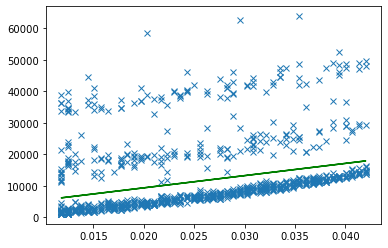

B0: [1650.5818], B1: [[387251.56]]


In [56]:
beta1, beta0 = network.parameters()

beta0 = beta0.data.numpy()
beta1 = beta1.data.numpy()

yplot = X_train * beta1 + beta0
plt.plot(X_train, y_train, 'x');
plt.plot(X_train, yplot.reshape(-1, 1), 'g')
plt.show()

print(f'B0: {beta0}, B1: {beta1}')

# References

https://stackoverflow.com/questions/44429199/how-to-load-a-list-of-numpy-arrays-to-pytorch-dataset-loader
https://towardsdatascience.com/linear-regression-with-pytorch-eb6dedead817

# ToDo

- Loss is high, check if normalizing output helps.
- Model is converging now, but is still little bit different from sklearn
Options to do:
- Normalize outputs and train model again. Might no needed.
- What is the difference between a model and nn.Linear?
- Repair log output to display meaningful data